In [1]:
import re
import email
import os
from stop_words import get_stop_words
from gensim import corpora, models, utils
from nltk.stem.porter import PorterStemmer
from nltk import clean_html
from bs4 import BeautifulSoup
from collections import defaultdict

import pyLDAvis
import pyLDAvis.gensim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# Read emails from csv

file_name = os.path.join("C:", os.sep, "dataset", "personnal_emails", "email_perso.csv")
full_data = pd.read_csv(file_name, encoding='latin1')
body = full_data["Body"]
subjects = full_data["Subject"]
print(full_data)

                                              Subject         Date Sent  \
0                                Welcome to Upskills!  14/05/2019 09:04   
1   Reminder - Upskills Brown Bag Session - Confir...  13/05/2019 11:53   
2   Canceled: Upskills Training - Fundamental Revi...  13/05/2019 09:33   
3      You've been added to a team in Microsoft Teams  14/05/2019 11:41   
4            Asset Delivery Sign-off, action required  14/05/2019 12:14   
5                  Scb agrees to award us the project  14/05/2019 16:04   
6              RE: Scb agrees to award us the project  14/05/2019 16:19   
7                                   RE: OCBC tomorrow  15/05/2019 17:00   
8                                   Azure Credentials  17/05/2019 10:06   
9                               Re: Azure Credentials  17/05/2019 10:38   
10                                     FW: Case Study  17/05/2019 11:29   
11                              Re: Azure Credentials  17/05/2019 12:07   
12                       

In [63]:
# Clean subjects : lower and remove RE and FWD
sub = []
for row_id in subjects.index:
    print(subjects.iloc[row_id])
    normalized_subject = re.sub("((re)|(fwd?)).?: ", "", subjects.iloc[row_id].lower())
    if len(normalized_subject) >= 1:
        sub.append(normalized_subject)
        print("___________")
    
unique_subjects = list(set(sub))
#print(sub)
print(set(sub))

Welcome to Upskills!
___________
Reminder - Upskills Brown Bag Session - Confirmation Matcher
___________
Canceled: Upskills Training - Fundamental Review of Trading Book (FRTB) Part 2
___________
You've been added to a team in Microsoft Teams
___________
Asset Delivery Sign-off, action required
___________
Scb agrees to award us the project
___________
RE: Scb agrees to award us the project
___________
RE: OCBC tomorrow
___________
Azure Credentials
___________
Re: Azure Credentials
___________
FW: Case Study
___________
Re: Azure Credentials
___________
Re: Azure Credentials
___________
Re: Azure Credentials
___________
Re: Azure Credentials
___________
RE: Azure Credentials
___________
RE: Azure Credentials
___________
RE: Azure Credentials
___________
RE: Azure Credentials
___________
Utiliser le binary encoder pour reduire la dimension 
___________
RE: Azure Credentials
___________
RE: projets upskills
___________
Re: email adress creation
___________
Re: email adress creation
___

In [64]:
len(unique_subjects)

38

In [31]:
msg = {}
for row_id in body.index:
    msg[row_id] = body.iloc[row_id]

key_list = list(msg.keys())

In [32]:
msg

{0: 'Dear Aurelien,  We warmly welcome you at Upskills and believe we will have some extraordinary journey together!  Please find below some useful information:  \x95 Confidentiality of Data: please be reminded that the information you might be given access to can be confidential and restricted.  Always be mindful of your obligations in regards of accessing, transmitting or otherwise using confidential/proprietary information, whether it be Upskills internal, or from one of the customers you are assigned to.  In particular never attempt to copy, transmit, or otherwise extract any information(data, programs, code, documents, etc..) to outside of the organization, in any form, without prior written approval from your management and/or the customer.  Do refer to the employee handbook for more details, and take note of the possible severe consequences in terms of breach.  \x95 Passwords: Please make sure to keep your passwords safe and secure and do not share with anyone (except if request

In [4]:
# Processing data definition
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
en_stop = get_stop_words('en')
en_stop.append("com")
en_stop.append("www")
en_stop.append("[IMAGE]")

In [5]:
# Message pre processing

cleaned_msg = {}
minimal_character = 70
max_count = 70
count = 0
for __, message in msg.items():
    #Remove the original message from the body
    # clean_body = message[0:message.find("-----Original Message-----")] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    clean_body = message
    # Remove all URL links
    body_linkless = re.sub(r"http\S+", "", clean_body)
    # Remove html code
    soup = BeautifulSoup(body_linkless)
    body_linkless = soup.get_text()
    # Remove [image]
    body_linkless = body_linkless.replace("[IMAGE]", "")
    # Remove email redundant fields
    body_linkless = re.sub(r"(From|De.): .*?(Subject|Objet.):.", "", body_linkless)
    # Remove email subject abbreviations
    body_linkless = re.sub(r"(\b[Ff][Ww][Dd]?\b|\b[Rr][Ee]\b).?:", "", body_linkless)
    # Remove underscores
    body_linkless = re.sub(r"_", "", body_linkless)
    # Remove useless ads text
    body_linkless = re.sub(r"(Get|Sent).*<", "", body_linkless)
    # Remove condential statement
    body_linkless = re.sub(r"CONFIDENTIAL NOTE.*", "", body_linkless)
    # Save only if contains minimal token number
    if len(body_linkless) > minimal_character:
        cleaned_msg[count] = body_linkless
        count += 1
        if count > max_count:
            break

In [6]:
for key, mes in cleaned_msg.items():
    print(key)
    print(mes)
    print("-"*100)

0
Dear Aurelien,  We warmly welcome you at Upskills and believe we will have some extraordinary journey together!  Please find below some useful information:   Confidentiality of Data: please be reminded that the information you might be given access to can be confidential and restricted.  Always be mindful of your obligations in regards of accessing, transmitting or otherwise using confidential/proprietary information, whether it be Upskills internal, or from one of the customers you are assigned to.  In particular never attempt to copy, transmit, or otherwise extract any information(data, programs, code, documents, etc..) to outside of the organization, in any form, without prior written approval from your management and/or the customer.  Do refer to the employee handbook for more details, and take note of the possible severe consequences in terms of breach.   Passwords: Please make sure to keep your passwords safe and secure and do not share with anyone (except if requested by aut

In [7]:
def word_frequency_filter(texts, count_threshold):
    """Remove word whose frequency is less than a count threshold
    """

    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    return [[token for token in text if frequency[token] > count_threshold] for text in texts ] 

In [8]:
# Text preprocess
processed_msg = {}
raw_message = []
for key, document in cleaned_msg.items():
    # raw = document.lower() # use less with simple token
    tokens = utils.simple_preprocess(document, min_len=3)
    # print(tokens)
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if (not i in en_stop)]
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    print(key)
    # Lemmatize ?
    print(stemmed_tokens)
    # Remove tokens that not appear enough in the corpus
    # remove words that appear only once
    st_tokens = word_frequency_filter(stemmed_tokens, 2)
    print("-"*100)
    
    processed_msg[key] = stemmed_tokens
    
    
    raw_message.append(document)


0
['dear', 'aurelien', 'warmli', 'welcom', 'upskil', 'believ', 'will', 'extraordinari', 'journey', 'togeth', 'pleas', 'find', 'use', 'inform', 'confidenti', 'data', 'pleas', 'remind', 'inform', 'might', 'given', 'access', 'can', 'confidenti', 'restrict', 'alway', 'mind', 'oblig', 'regard', 'access', 'transmit', 'otherwis', 'use', 'confidenti', 'proprietari', 'inform', 'whether', 'upskil', 'intern', 'one', 'custom', 'assign', 'particular', 'never', 'attempt', 'copi', 'transmit', 'otherwis', 'extract', 'inform', 'data', 'program', 'code', 'document', 'etc', 'outsid', 'organ', 'form', 'without', 'prior', 'written', 'approv', 'manag', 'custom', 'refer', 'employe', 'handbook', 'detail', 'take', 'note', 'possibl', 'sever', 'consequ', 'term', 'breach', 'password', 'pleas', 'make', 'sure', 'keep', 'password', 'safe', 'secur', 'share', 'anyon', 'except', 'request', 'author', 'personnel', 'superior', 'ask', 'chang', 'password', 'make', 'sure', 'use', 'password', 'least', 'charact', 'upper', 'cas

28
['aurelien', 'pleas', 'find', 'answer', 'sold', 'custom', 'explan', 'root', 'caus', 'mismatch', 'detect', 'version', 'murex', 'sarah', 'ye', 'cluster', 'tool', 'also', 'sold', 'servic', 'associ', 'sarah', 'servic', 'cluster', 'prove', 'effici', 'big', 'data', 'abl', 'simplifi', 'usag', 'ba', 'busi', 'model', 'can', 'chang', 'cluster', 'tool', 'didn', 'exist', 'ba', 'analys', 'line', 'one', 'one', 'standard', 'method', 'use', 'don', 'cluster', 'tool', 'acceler', 'work', 'sarah', 'wont', 'line', 'line', 'will', 'combin', 'method', 'method', 'cluster', 'human', 'brain', 'ba', 'will', 'abl', 'identifi', 'pattern', 'limit', 'number', 'column', 'exempl', 'howev', 'brain', 'limit', 'will', 'prevent', 'column', 'cluster', 'bring', 'ad', 'valu', 'way', 'will', 'identifi', 'group', 'deal', 'want', 'analys', 'first', 'find', 'root', 'caus', 'method', 'one', 'first', 'root', 'caus', 'identifi', 'sometim', 'abl', 'identifi', 'deal', 'associ', 'deal', 'curr', 'eur', 'will', 'problem', 'eur', 'cur

44
['base', 'databas', 'model', 'document', 'made', 'present', 'pleas', 'tell', 'need', 'add', 'remov', 'someth', 'full', 'view', 'time', 'line', 'fast', 'track', 'aurelien', 'hussam', 'monday', 'will', 'meet', 'steer', 'narr', 'meet', 'monday', 'around', 'final', 'data', 'architectur', 'complet', 'direct', 'clear', 'aw', 'dynamodb', 'document', 'data', 'model', 'stump', 'relat', 'model', 'ccbuddi', 'need', 'understand', 'access', 'pattern', 'can', 'facilit', 'design', 'incorpor', 'clearli', 'client', 'relat', 'entiti', 'awar', 'use', 'case', 'surround', 'servic', 'know', 'like', 'recommend', 'engin', 'might', 'good', 'tacitli', 'extract', 'inform', 'fast', 'track', 'time', 'line', 'choic', 'db', 'uob', 'ocbc', 'chosen', 'ocbc', 'arbitrarili', 'gener', 'standard', 'specif', 'ocbc', 'relat', 'cut', 'extract', 'transform', 'load', 'etl', 'process', 'will', 'design', 'will', 'good', 'idea', 'part', 'etl', 'process', 'need', 'generalis', 'idiosyncrat', 'bank', 'aw', 'dynamodb', 'lambda', '

In [9]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary([ email for _, email in processed_msg.items()])

In [10]:
number_topic = 7
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for _, text in processed_msg.items()]

# generate LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=number_topic, id2word=dictionary, passes=100)

ldamodel.print_topics(num_topics = number_topic, num_words=10)

[(0,
  '0.068*"email" + 0.032*"aurelien" + 0.026*"group" + 0.026*"pleas" + 0.025*"regard" + 0.023*"can" + 0.022*"address" + 0.019*"pavilion" + 0.019*"thong" + 0.019*"classif"'),
 (1,
  '0.030*"can" + 0.025*"deal" + 0.019*"mani" + 0.014*"need" + 0.014*"feel" + 0.013*"use" + 0.013*"think" + 0.013*"read" + 0.013*"merchant" + 0.013*"seem"'),
 (2,
  '0.024*"team" + 0.016*"bank" + 0.016*"github" + 0.010*"aurelien" + 0.008*"upskil" + 0.008*"meet" + 0.008*"may" + 0.008*"georg" + 0.008*"discuss" + 0.008*"saim"'),
 (3,
  '0.018*"sarah" + 0.017*"cluster" + 0.017*"aurelien" + 0.014*"tool" + 0.014*"version" + 0.012*"can" + 0.012*"will" + 0.012*"use" + 0.012*"root" + 0.012*"caus"'),
 (4,
  '0.052*"azur" + 0.039*"lambda" + 0.035*"credenti" + 0.034*"thong" + 0.031*"thank" + 0.027*"tuan" + 0.024*"pleas" + 0.024*"function" + 0.024*"can" + 0.021*"access"'),
 (5,
  '0.032*"manag" + 0.027*"email" + 0.023*"employe" + 0.020*"case" + 0.018*"asset" + 0.018*"laptop" + 0.017*"use" + 0.015*"pleas" + 0.014*"config

In [11]:
for count, c in enumerate(ldamodel[corpus]):
    print(c)
    print("document number : {}".format(count))   
    print("------------------------------------------------------\n")

[(5, 0.25862056), (6, 0.7395513)]
document number : 0
------------------------------------------------------

[(6, 0.9739707)]
document number : 1
------------------------------------------------------

[(6, 0.9859166)]
document number : 2
------------------------------------------------------

[(2, 0.9883905)]
document number : 3
------------------------------------------------------

[(5, 0.9952845)]
document number : 4
------------------------------------------------------

[(6, 0.97136885)]
document number : 5
------------------------------------------------------

[(6, 0.980018)]
document number : 6
------------------------------------------------------

[(3, 0.9790213)]
document number : 7
------------------------------------------------------

[(4, 0.942798)]
document number : 8
------------------------------------------------------

[(4, 0.95485246)]
document number : 9
------------------------------------------------------

[(0, 0.08861192), (4, 0.74061805), (6, 0.15610036)]
d

In [12]:
for count, c in enumerate(ldamodel[corpus]):
    print("document number : {}".format(count))
    print(cleaned_msg[key_list[count]])
    print("Results     : ", c)
    print("------------------------------------------------------\n")

document number : 0
Dear Aurelien,  We warmly welcome you at Upskills and believe we will have some extraordinary journey together!  Please find below some useful information:   Confidentiality of Data: please be reminded that the information you might be given access to can be confidential and restricted.  Always be mindful of your obligations in regards of accessing, transmitting or otherwise using confidential/proprietary information, whether it be Upskills internal, or from one of the customers you are assigned to.  In particular never attempt to copy, transmit, or otherwise extract any information(data, programs, code, documents, etc..) to outside of the organization, in any form, without prior written approval from your management and/or the customer.  Do refer to the employee handbook for more details, and take note of the possible severe consequences in terms of breach.   Passwords: Please make sure to keep your passwords safe and secure and do not share with anyone (except i

In [13]:
vis = pyLDAvis.gensim.prepare(topic_model=ldamodel, corpus=corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

c:\python37-32\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [14]:
ldamodel.get_document_topics(corpus[0])

[(5, 0.2586208), (6, 0.73955107)]

In [15]:
ldamodel.get_topics()

array([[1.0547041e-02, 6.1112330e-03, 1.0594512e-04, ..., 8.4738870e-04,
        8.4738870e-04, 8.4738870e-04],
       [4.9216994e-03, 2.2371781e-04, 2.2371777e-04, ..., 2.2371777e-04,
        2.2371777e-04, 2.2371777e-04],
       [2.2336966e-04, 2.2423521e-04, 2.2336959e-04, ..., 2.2336959e-04,
        2.2336959e-04, 2.2336959e-04],
       ...,
       [2.1450961e-02, 5.9943232e-03, 1.4167601e-04, ..., 1.4167601e-04,
        1.4167601e-04, 1.4167601e-04],
       [3.2191433e-04, 4.8195394e-03, 3.2473422e-04, ..., 3.2141223e-04,
        3.2141223e-04, 3.2141223e-04],
       [1.2827583e-02, 7.4850795e-05, 5.9551123e-04, ..., 7.4564254e-05,
        7.4564254e-05, 7.4564254e-05]], dtype=float32)

In [16]:
ldamodel.show_topics()

[(0,
  '0.068*"email" + 0.032*"aurelien" + 0.026*"group" + 0.026*"pleas" + 0.025*"regard" + 0.023*"can" + 0.022*"address" + 0.019*"pavilion" + 0.019*"thong" + 0.019*"classif"'),
 (1,
  '0.030*"can" + 0.025*"deal" + 0.019*"mani" + 0.014*"need" + 0.014*"feel" + 0.013*"use" + 0.013*"think" + 0.013*"read" + 0.013*"merchant" + 0.013*"seem"'),
 (2,
  '0.024*"team" + 0.016*"bank" + 0.016*"github" + 0.010*"aurelien" + 0.008*"upskil" + 0.008*"meet" + 0.008*"may" + 0.008*"georg" + 0.008*"discuss" + 0.008*"saim"'),
 (3,
  '0.018*"sarah" + 0.017*"cluster" + 0.017*"aurelien" + 0.014*"tool" + 0.014*"version" + 0.012*"can" + 0.012*"will" + 0.012*"use" + 0.012*"root" + 0.012*"caus"'),
 (4,
  '0.052*"azur" + 0.039*"lambda" + 0.035*"credenti" + 0.034*"thong" + 0.031*"thank" + 0.027*"tuan" + 0.024*"pleas" + 0.024*"function" + 0.024*"can" + 0.021*"access"'),
 (5,
  '0.032*"manag" + 0.027*"email" + 0.023*"employe" + 0.020*"case" + 0.018*"asset" + 0.018*"laptop" + 0.017*"use" + 0.015*"pleas" + 0.014*"config

In [69]:
topic = 4
for count, c in enumerate(ldamodel[corpus]):
    for cc in c:
        if cc[0] == topic:
            print("document number : {}".format(count))
            print(cleaned_msg[key_list[count]])
            print("\n")
            print("Topics number      : ", c[0])
            print(ldamodel.print_topic(c[0][0]))
            print("\n")
            print("similarity index : {}".format(c[0][1]))
            print("\n")
            print(processed_msg[count])
            print("------------------------------------------------------\n")

document number : 8
Hi Nam, Tuan, Hai,  Could you please help to grant the access to George and Aurelien (and their team) to Azure for dev?  Thanks  Thong  


Topics number      :  (4, 0.9427997)
0.052*"azur" + 0.039*"lambda" + 0.035*"credenti" + 0.034*"thong" + 0.031*"thank" + 0.027*"tuan" + 0.024*"pleas" + 0.024*"function" + 0.024*"can" + 0.021*"access"


similarity index : 0.9427996873855591


['nam', 'tuan', 'hai', 'pleas', 'help', 'grant', 'access', 'georg', 'aurelien', 'team', 'azur', 'dev', 'thank', 'thong']
------------------------------------------------------

document number : 9
Not azure aws         Azure Credentials    Hi Nam, Tuan, Hai,  Could you please help to grant the access to George and Aurelien (and their team) to Azure for dev?  Thanks  Thong  


Topics number      :  (4, 0.9548526)
0.052*"azur" + 0.039*"lambda" + 0.035*"credenti" + 0.034*"thong" + 0.031*"thank" + 0.027*"tuan" + 0.024*"pleas" + 0.024*"function" + 0.024*"can" + 0.021*"access"


similarity index : 0

(array([1., 2., 1., 1., 6., 4., 3., 2., 2., 3., 3., 2., 1., 0., 3., 2., 0.,
        0., 1., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 2., 0., 0.,
        2., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 136.  ,  177.73,  219.46,  261.19,  302.92,  344.65,  386.38,
         428.11,  469.84,  511.57,  553.3 ,  595.03,  636.76,  678.49,
         720.22,  761.95,  803.68,  845.41,  887.14,  928.87,  970.6 ,
        1012.33, 1054.06, 1095.79, 1137.52, 1179.25, 1220.98, 1262.71,
        1304.44, 1346.17, 1387.9 , 1429.63, 1471.36, 1513.09, 1554.82,
        1596.55, 1638.28, 1680.01, 1721.74, 1763.47, 1805.2 , 1846.93,
        1888.66, 1930.39, 1972.12, 2013.85, 2055.58, 2097.31, 2139.04,
        2180.77, 2222.5 , 2264.23, 2305.96, 2347.69, 

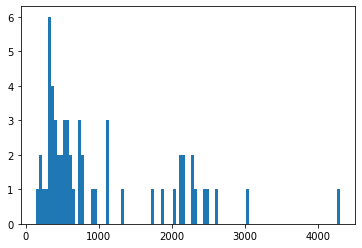

In [18]:
msg_len = [len(mess) for _, mess in cleaned_msg.items()]
plt.hist(msg_len, 100)

Minimal length of documet should be 70 character